In [1]:
import pandas as pd
from scipy import stats
import numpy as np
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Get similarity scores using each method

In [2]:
# Get similarity scores
similarities = pd.read_csv('../../data/network_method/similarities_10m.csv')
stein_similarities1 = pd.read_csv('../../data/network_method/similarities_10m_stein_0.6_3.csv')
stein_similarities2 = pd.read_csv('../../data/network_method/similarities_10m_stein_0.5_2.csv')
stein_similarities3 = pd.read_csv('../../data/network_method/similarities_10m_stein_0.5_0.5.csv')
stein_similarities4 = pd.read_csv('../../data/network_method/similarities_10m_stein_0.53_1.3.csv')
binary_similarities = pd.read_csv('../../data/network_method/similarities_10m_binary.csv')
no_mz_similarities = pd.read_csv('../../data/network_method/similarities_10m_without_mz.csv')


In [6]:
all_similarities = {
    'our_weights' : similarities, 
    'Stein_and_Scott': stein_similarities1,
    'Horai': stein_similarities2, 
    'Sokolow': stein_similarities3,
    'Kim': stein_similarities4,
    'binary': binary_similarities,
    'no_mz': no_mz_similarities
}

In [7]:
# Remove rows without a tnaimoto score
for name in all_similarities.keys():
    all_similarities[name] = all_similarities[name].loc[~pd.isna(all_similarities[name]['tanimoto'])]

In [8]:
similarities_tanimoto = {}
for name in all_similarities.keys():
    all_similarities[name]["tanimoto_interval"] = pd.cut(
        all_similarities[name]["tanimoto"],
        5,
        labels=["0.0–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8", "0.8–1.0"],
    )
    similarities_tanimoto[name] = pd.melt(
        all_similarities[name],
        id_vars="tanimoto_interval",
        value_vars=["weighted_modified_cosine", "modified_cosine"],
    )

/var/folders/42/5d8q8sxj7jl7qbzh9rsv75bw0000gn/T/ipykernel_98586/2895035681.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_similarities[name]["tanimoto_interval"] = pd.cut(
/var/folders/42/5d8q8sxj7jl7qbzh9rsv75bw0000gn/T/ipykernel_98586/2895035681.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_similarities[name]["tanimoto_interval"] = pd.cut(
/var/folders/42/5d8q8sxj7jl7qbzh9rsv75bw0000gn/T/ipykernel_98586/2895035681.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

# Calculate KL divergence for each weighting method

In [9]:
# Create df
kl_div_df = pd.DataFrame(columns=['kl_div'])

# Calculate probability density functions
tanimoto_kde = stats.gaussian_kde(np.array(list(all_similarities['our_weights'].tanimoto)))
modified_cosine_kde = stats.gaussian_kde(np.array(list(all_similarities['our_weights'].modified_cosine)))

# Calculate KL divergence for unweighted method
x_vals = np.linspace(0, 1, 200)
kl_div_df.loc['no_weights'] = stats.entropy(modified_cosine_kde(x_vals), tanimoto_kde(x_vals))

# Calculate KL divergence for each weighted method
for name in tqdm(all_similarities.keys()):
    current_kde = stats.gaussian_kde(np.array(list(all_similarities[name].weighted_modified_cosine)))
    kl_div_df.loc[name] = stats.entropy(current_kde(x_vals), tanimoto_kde(x_vals))



100%|██████████| 7/7 [01:31<00:00, 13.01s/it]


In [10]:
kl_div_df

,kl_div
no_weights,3.056391
our_weights,1.119889
Stein_and_Scott,2.541085
Horai,2.017623
Sokolow,1.558186
Kim,1.833279
binary,1.184707
no_mz,1.161672


# Look at cutoffs for pairs with tanimoto > 0.8

In [11]:
# Create dataframe
num_above = pd.DataFrame(columns=['num_above_0.5', 'num_above_0.6', 'num_above_0.7', 'num_above_0.8', 'num_above_0.9'])

# Count num scores above 0.7 for unweighted method
current_df = all_similarities['our_weights'].loc[all_similarities['our_weights']['tanimoto'] > 0.8]
num_above.loc['no_weights', 'num_above_0.5'] = len(current_df.loc[current_df['modified_cosine'] > 0.5])
num_above.loc['no_weights', 'num_above_0.6'] = len(current_df.loc[current_df['modified_cosine'] > 0.6])
num_above.loc['no_weights', 'num_above_0.7'] = len(current_df.loc[current_df['modified_cosine'] > 0.7])
num_above.loc['no_weights', 'num_above_0.8'] = len(current_df.loc[current_df['modified_cosine'] > 0.8])
num_above.loc['no_weights', 'num_above_0.9'] = len(current_df.loc[current_df['modified_cosine'] > 0.9])

# Count num scores above 0.7 for each weighted method
for name in tqdm(all_similarities.keys()):
    current_df = all_similarities[name].loc[all_similarities[name]['tanimoto'] > 0.8]
    num_above.loc[name, 'num_above_0.5'] = len(current_df.loc[current_df['weighted_modified_cosine'] > 0.5])
    num_above.loc[name, 'num_above_0.6'] = len(current_df.loc[current_df['weighted_modified_cosine'] > 0.6])
    num_above.loc[name, 'num_above_0.7'] = len(current_df.loc[current_df['weighted_modified_cosine'] > 0.7])
    num_above.loc[name, 'num_above_0.8'] = len(current_df.loc[current_df['weighted_modified_cosine'] > 0.8])
    num_above.loc[name, 'num_above_0.9'] = len(current_df.loc[current_df['weighted_modified_cosine'] > 0.9])

100%|██████████| 7/7 [00:43<00:00,  6.23s/it]


In [12]:
num_above

,num_above_0.5,num_above_0.6,num_above_0.7,num_above_0.8,num_above_0.9
no_weights,4038,3549,3023,2424,1727
our_weights,4131,2921,1785,820,220
Stein_and_Scott,3727,3076,2428,1718,1023
Horai,3932,3066,2277,1474,780
Sokolow,4424,3453,2519,1554,728
Kim,4205,3279,2441,1545,819
binary,2317,1269,595,215,58
no_mz,3822,2626,1469,612,176


7it [01:26, 12.30s/it]


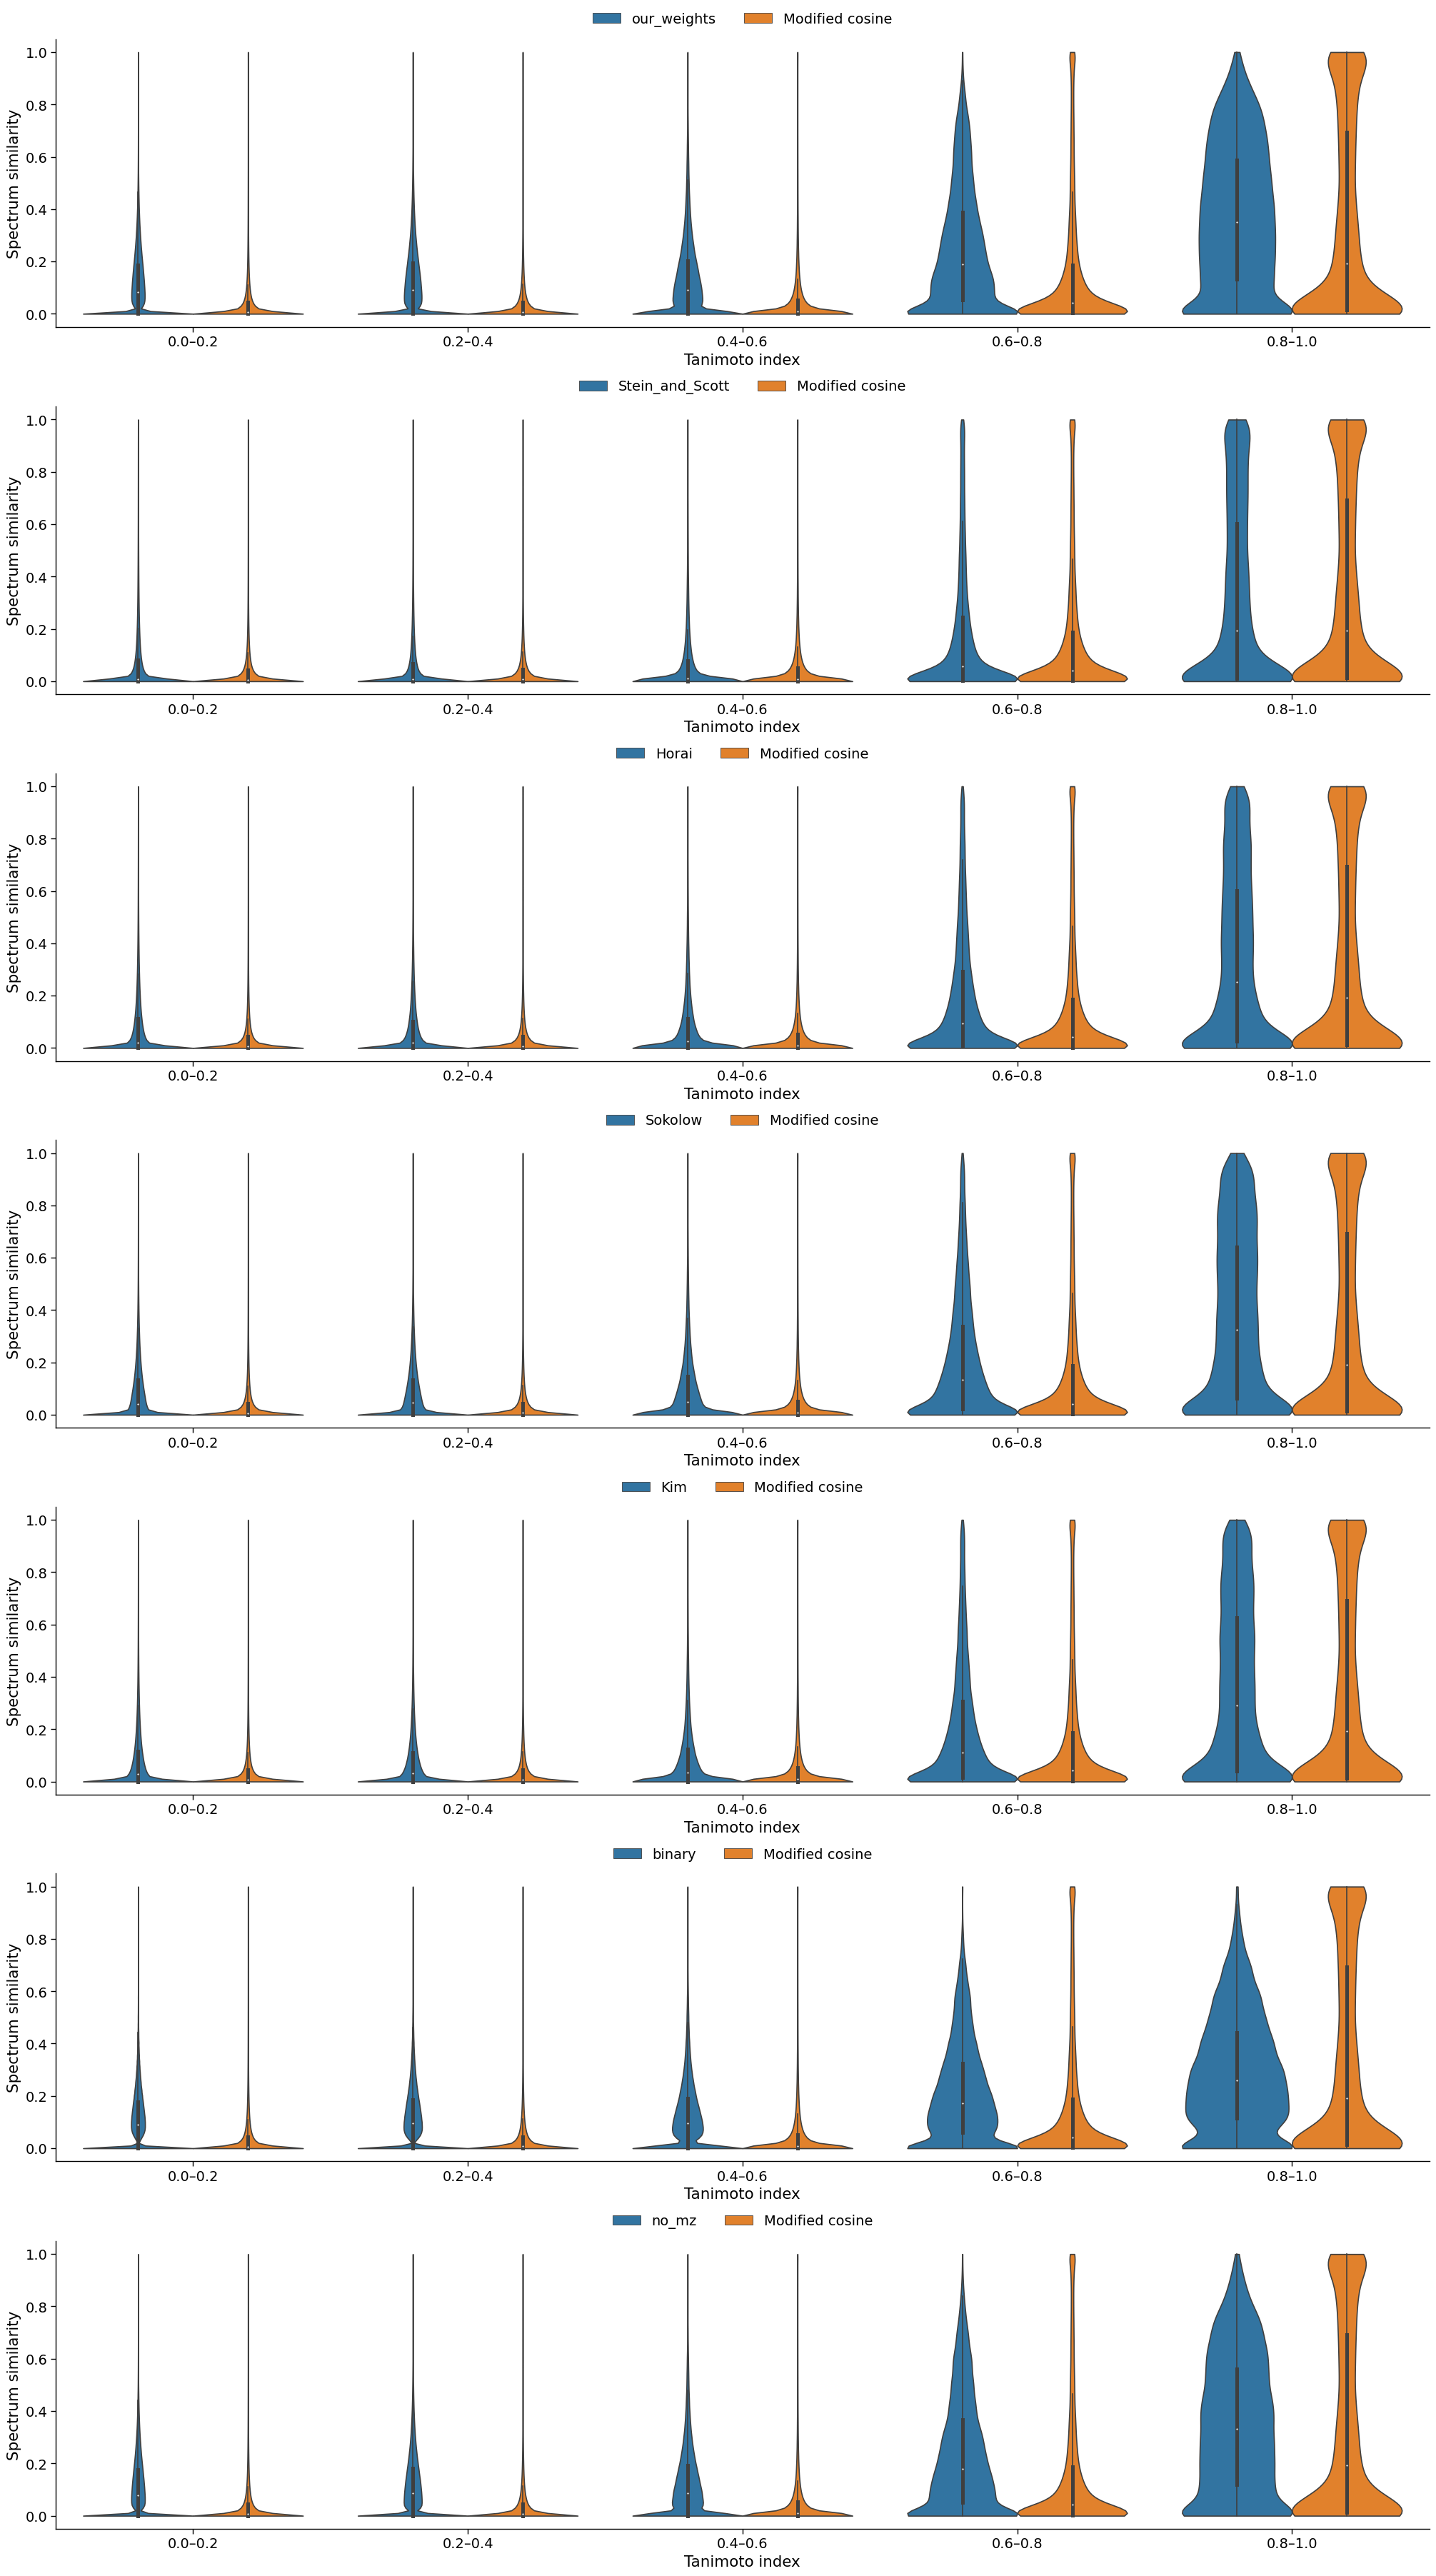

In [23]:
with sns.plotting_context("paper", font_scale=1.6):

    label_dict = {
        "modified_cosine": "Modified cosine",
        "weighted_modified_cosine": "Modified cosine (weighted)",
        "entropy": "Spectral entropy",
        "weighted_entropy": "Spectral entropy (weighted)",
        "bhattacharya_1": "Bhattacharya distance",
        "weighted_bhattacharya_1": "Bhattacharya 1 (weighted)",
        "fidelity": "Fidelity",
        "weighted_fidelity": "Fidelity (weighted)",
    }

    fig = plt.figure(constrained_layout=True, figsize=(20, 40))

    gs = GridSpec(8, 1, figure=fig)

    

    for i, name in tqdm(enumerate(all_similarities.keys())):
        ax = fig.add_subplot(gs[i])
        sns.violinplot(
            data=similarities_tanimoto[name],
            x="tanimoto_interval",
            y="value",
            hue="variable",
            hue_order=["weighted_modified_cosine", "modified_cosine"],
            cut=0,
            scale="width",
            scale_hue=False,
            ax=ax,
        )
        ax.set_xlabel("Tanimoto index")
        ax.set_ylabel("Spectrum similarity")
        for label in ax.legend().get_texts():
            if label.get_text() == "modified_cosine":
                label.set_text(
                    "Modified cosine"
                )
            else:
                label.set_text(
                    name
                )
        sns.move_legend(
            ax,
            "lower center",
            bbox_to_anchor=(.5, 1),
            ncol=3,
            title=None,
            frameon=False,
        )

        sns.despine(ax=ax)

    # # Save figure.
    #plt.savefig("benchmark_metrics.png", dpi=400, bbox_inches="tight")
    plt.show()
    plt.close()

In [24]:

similarities_tanimoto[name]

,tanimoto_interval,variable,value
0,0.0–0.2,weighted_modified_cosine,0.213143
1,0.0–0.2,weighted_modified_cosine,0.000000
2,0.2–0.4,weighted_modified_cosine,0.065383
3,0.0–0.2,weighted_modified_cosine,0.062982
4,0.0–0.2,weighted_modified_cosine,0.000000
...,...,...,...
19226983,0.2–0.4,modified_cosine,0.025377
19226984,0.2–0.4,modified_cosine,0.010107
19226985,0.0–0.2,modified_cosine,0.000000
19226986,0.2–0.4,modified_cosine,0.085822


100%|██████████| 7/7 [00:00<00:00,  8.41it/s]


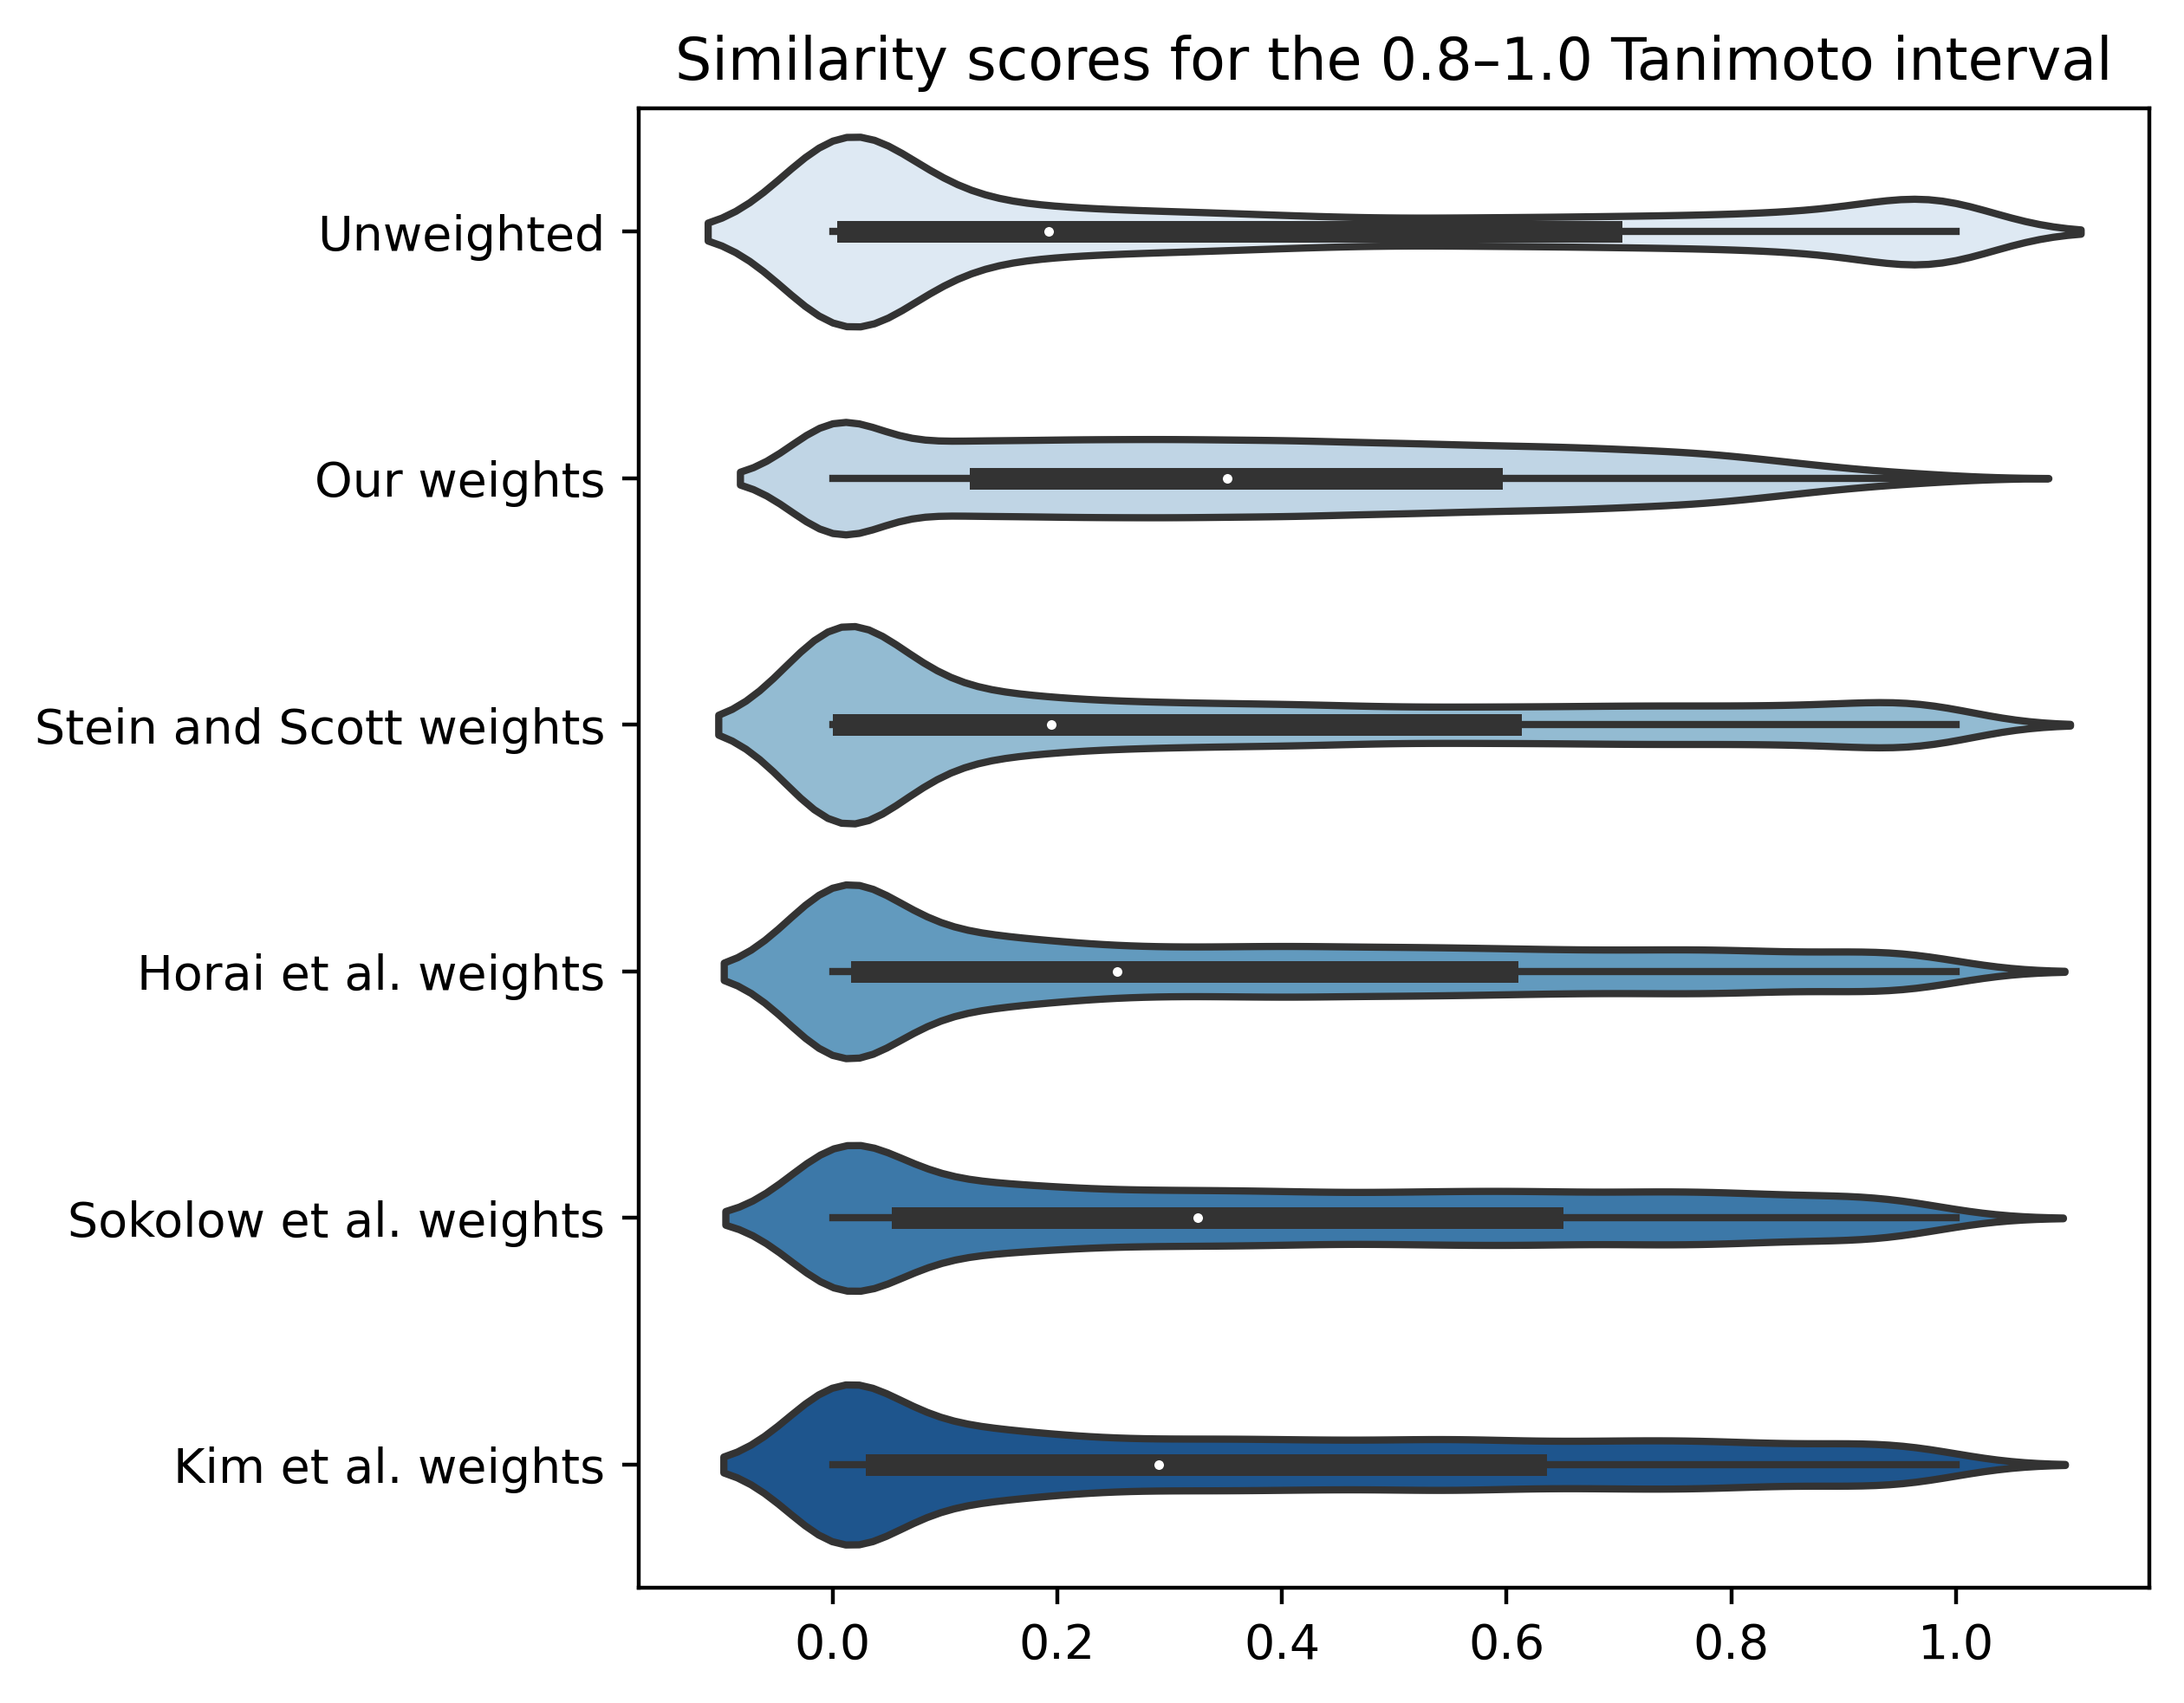

In [63]:
# Set initial variables
figures = []
colors = ['#eca86f', 
            '#e96f3d', 
            '#d73c24',
            '#0d2b53',
            '#1d6d8b', 
            '#2f8895', 
            '#82a8a0']
name_dict = {'binary': 'Binary weights',
            'no_mz': 'No m/z Weights',
            'our_weights': 'Our weights',
            'Stein_and_Scott': 'Stein and Scott weights',
            'Horai': 'Horai et al. weights',
            'Sokolow': 'Sokolow et al. weights',
            'Kim': 'Kim et al. weights'}


# Load unweighted data
current_df = similarities_tanimoto[name].\
        loc[similarities_tanimoto[name].tanimoto_interval == '0.8–1.0']
current_df = current_df.loc[current_df.variable == 'modified_cosine']
figures.append(current_df.value)

# Load weighted data
for name in tqdm(all_similarities.keys()):
    if name not in ['binary', 'no_mz']:
        current_df = similarities_tanimoto[name].\
            loc[similarities_tanimoto[name].tanimoto_interval == '0.8–1.0']
        current_df = current_df.loc[current_df.variable == 'weighted_modified_cosine']
        figures.append(np.array(list(current_df.value)))

# Create violin plot
figures = np.array(figures).T
plt.figure(dpi=400)
sns.violinplot(data=figures, palette='Blues', orient='h')
plt.yticks(np.arange(0, 6), 
['Unweighted'] + [name_dict[x] for x in list(all_similarities.keys())[:-2]])
plt.tight_layout()
plt.title('Similarity scores for the 0.8–1.0 Tanimoto interval')
plt.savefig('../../figures/4_compare_scores.png', dpi=400, bbox_inches='tight')
plt.show()